Task 1

In [93]:
import pandas as pd

In [94]:
# Load and make a deep copy of the dataset
df_raw = pd.read_csv("online_shoppers_intention.csv")
df = df_raw.copy(deep=True) 

In [95]:
# Quick overview
print("Shape :", df.shape)
print("Types : ", df.dtypes)
display(df.head(3))


Shape : (12330, 18)
Types :  Administrative               int64
Administrative_Duration    float64
Informational                int64
Informational_Duration     float64
ProductRelated               int64
ProductRelated_Duration    float64
BounceRates                float64
ExitRates                  float64
PageValues                 float64
SpecialDay                 float64
Month                       object
OperatingSystems             int64
Browser                      int64
Region                       int64
TrafficType                  int64
VisitorType                 object
Weekend                       bool
Revenue                       bool
dtype: object


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.0,0.0,0.1,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.0,0.2,0.2,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False


In [96]:
df.columns.str.strip()

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [97]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [98]:
# SIMPLE STRUCTURAL CHECKS
# missing values
missing = df.isna().sum()
print("\nMissing values (non-zero only):")
print(missing[missing > 0])

# 3.3 duplicates
dup_count = df.duplicated().sum()
print("\nExact duplicate rows:", dup_count)



Missing values (non-zero only):
Series([], dtype: int64)

Exact duplicate rows: 125


In [99]:
# drop duplicates
before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
after = df.shape[0]
print(f"Removed {before-after} duplicate rows. New shape: {df.shape}")


Removed 125 duplicate rows. New shape: (12205, 18)


In [100]:
df.columns

Index(['Administrative', 'Administrative_Duration', 'Informational',
       'Informational_Duration', 'ProductRelated', 'ProductRelated_Duration',
       'BounceRates', 'ExitRates', 'PageValues', 'SpecialDay', 'Month',
       'OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType',
       'Weekend', 'Revenue'],
      dtype='object')

In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12205 entries, 0 to 12204
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12205 non-null  int64  
 1   Administrative_Duration  12205 non-null  float64
 2   Informational            12205 non-null  int64  
 3   Informational_Duration   12205 non-null  float64
 4   ProductRelated           12205 non-null  int64  
 5   ProductRelated_Duration  12205 non-null  float64
 6   BounceRates              12205 non-null  float64
 7   ExitRates                12205 non-null  float64
 8   PageValues               12205 non-null  float64
 9   SpecialDay               12205 non-null  float64
 10  Month                    12205 non-null  object 
 11  OperatingSystems         12205 non-null  int64  
 12  Browser                  12205 non-null  int64  
 13  Region                   12205 non-null  int64  
 14  TrafficType           

In [102]:
for c in df.select_dtypes(include="object"):
    df[c] = df[c].str.strip().str.lower()
    print(f"Unique values in '{c}': {df[c].unique()}")

Unique values in 'Month': ['feb' 'mar' 'may' 'oct' 'june' 'jul' 'aug' 'nov' 'sep' 'dec']
Unique values in 'VisitorType': ['returning_visitor' 'new_visitor' 'other']


In [103]:
(df == "").any(axis=1).sum()

np.int64(0)

In [104]:
df.describe()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000,12205.000000
mean,2.338878,81.646331,0.508726,34.825454,32.045637,1206.982457,0.020370,0.041466,5.949574,0.061942,2.124211,2.357804,3.153298,4.073904
std,3.330436,177.491845,1.275617,141.424807,44.593649,1919.601400,0.045255,0.046163,18.653671,0.199666,0.906823,1.710114,2.402340,4.016654
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,8.000000,193.000000,0.000000,0.014231,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,9.000000,0.000000,0.000000,18.000000,608.942857,0.002899,0.025000,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,94.700000,0.000000,0.000000,38.000000,1477.154762,0.016667,0.048529,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [105]:
continuous_cols = ["Administrative", 
                   "Administrative_Duration", 
                   "Informational", 
                   "Informational_Duration", 
                   "ProductRelated", 
                   "ProductRelated_Duration", 
                   "BounceRates", 
                   "ExitRates", 
                   "PageValues", 
                   "SpecialDay"]

In [106]:
categorical_cols = ["Month", 
                    "OperatingSystems",
                    "VisitorType",
                    "Browser",
                    "Region",
                    "TrafficType",
                    "Weekend",
                    "Revenue"]

In [107]:
# Calculate Q1, Q3, and IQR for all continuous columns
Q1 = df[continuous_cols].quantile(0.25)
Q3 = df[continuous_cols].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

# Create a DataFrame showing whether each value is an outlier (True/False)
outlier_flags = (df[continuous_cols] < lower) | (df[continuous_cols] > upper)

# Optionally, count how many outliers per column
outlier_counts = outlier_flags.sum()

print("Outlier counts per column:\n", outlier_counts)

# If you want to see the actual rows with any outliers:
outlier_rows = df[outlier_flags.any(axis=1)]


Outlier counts per column:
 Administrative              404
Administrative_Duration    1149
Informational              2631
Informational_Duration     2405
ProductRelated             1007
ProductRelated_Duration     951
BounceRates                1428
ExitRates                  1325
PageValues                 2730
SpecialDay                 1249
dtype: int64


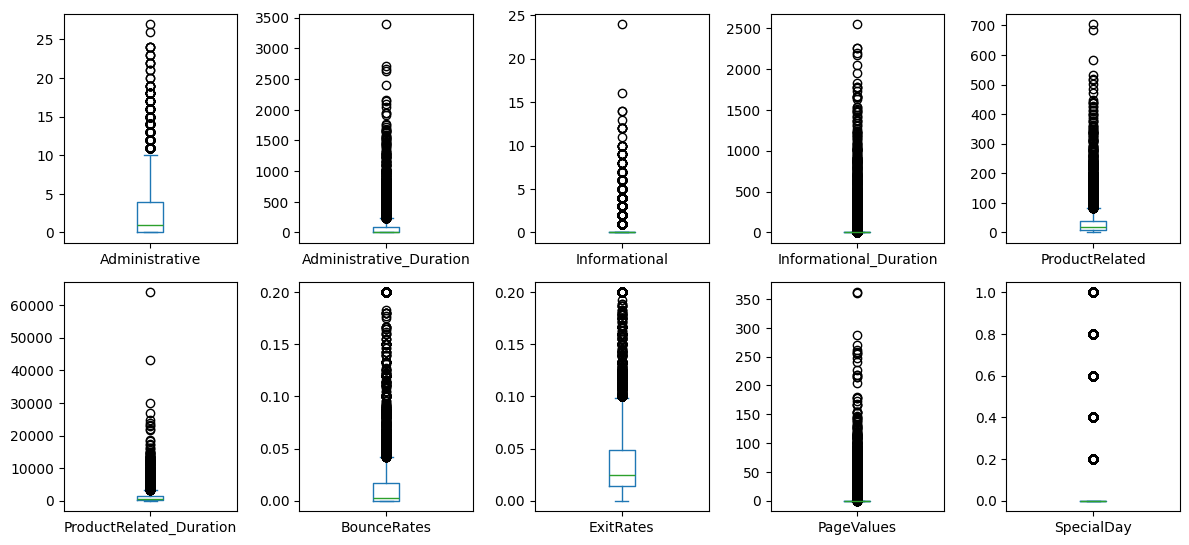

In [108]:
import matplotlib.pyplot as plt

df[continuous_cols].plot(kind="box", subplots=True, layout=(3,5), figsize=(12,8))
plt.tight_layout()


## <u>Task 2 — Feature Engineering (transformations + feature selection)</u>
We now define consistent preprocessing for **classification** and **clustering** using sklearn Pipelines.

Principles:
- Keep preprocessing inside a Pipeline/ColumnTransformer to ensure consistency across splits.
- Perform feature selection based on training data only.


### __2.1 - Train / Validation / Test split__
The dataset was split into training (70%), validation (15%), and test (15%) sets using stratified sampling to preserve the class distribution of the target variable. This ensured unbiased model evaluation and prevented information leakage during feature engineering and model selection.

In [109]:
from sklearn.model_selection import train_test_split

TARGET = "Revenue"
RANDOM_STATE = 42

X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y, random_state=RANDOM_STATE
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=RANDOM_STATE
)

print("Train:", X_train.shape)
print("Val:  ", X_val.shape)
print("Test: ", X_test.shape)


Train: (8543, 17)
Val:   (1831, 17)
Test:  (1831, 17)


### __2.2 - Feature grouping__
Different features need different transformations. Treating everything the same hurts performance and interpretability.

In [110]:
# Count features (zero-inflated, integer)
count_features = [
    "Administrative", "Informational", "ProductRelated"
]

# Duration & value features (heavy-tailed)
duration_features = [
    "Administrative_Duration", "Informational_Duration",
    "ProductRelated_Duration", "PageValues"
]

# Rate / bounded features
rate_features = [
    "BounceRates", "ExitRates", "SpecialDay"
]

# Encoded categoricals (already numeric labels, NOT ordinal)
encoded_cat_features = [
    "OperatingSystems", "Browser", "Region", "TrafficType"
]

# True categoricals
categorical_features = [
    "Month", "VisitorType"
]

# Binary
binary_features = ["Weekend"]


### __2.3 - Feature transformation choices / Preprocessing pipelines__

#### 2.3.1 Log-transform heavy-tailed features

Durations and PageValues have extreme outliers. Log transform:
- stabilizes variance
- reduces dominance of extreme values
- helps linear & distance-based models

We use log1p to handle zeros safely.

#### 2.3.2 Scaling

Required for clustering (distance-based)

Optional but helpful for classification models

We use StandardScaler.

#### 2.3.3 Encoding categoricals

Month, VisitorType → OneHotEncoder

Encoded numeric categories (Browser, Region, etc.) → treat as categorical, not ordinal → OneHotEncoder

Why not leave them numeric?
Their numeric labels have no order meaning. Leaving them numeric introduces fake ordinal relationships.

In [111]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
import numpy as np

log_transformer = FunctionTransformer(np.log1p, feature_names_out="one-to-one")

numeric_pipeline = Pipeline(steps=[
    ("log", log_transformer),
    ("scaler", StandardScaler())
])

rate_pipeline = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess_classification = ColumnTransformer(
    transformers=[
        ("counts", numeric_pipeline, count_features),
        ("durations", numeric_pipeline, duration_features),
        ("rates", rate_pipeline, rate_features),
        ("encoded_cat", categorical_pipeline, encoded_cat_features),
        ("categorical", categorical_pipeline, categorical_features),
        ("binary", "passthrough", binary_features),
    ],
    remainder="drop"
)

### __2.4 - Clustering preprocessing pipeline__

Differences from classification:

- No target
- Scaling is mandatory
- Same transformations → consistency

In [112]:
preprocess_clustering = ColumnTransformer(
    transformers=[
        ("counts", numeric_pipeline, count_features),
        ("durations", numeric_pipeline, duration_features),
        ("rates", rate_pipeline, rate_features),
        ("encoded_cat", categorical_pipeline, encoded_cat_features),
        ("categorical", categorical_pipeline, categorical_features),
        ("binary", "passthrough", binary_features),
    ],
    remainder="drop"
)

#### __2.5 - Correlation with target (classification)__

What you should observe:

- PageValues (log) → strong positive correlation
- Duration-related features → moderate
- BounceRates / ExitRates → negative

In [113]:
X_train_processed = preprocess_classification.fit_transform(X_train)
feature_names = preprocess_classification.get_feature_names_out()

X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)
corr_with_target = X_train_df.corrwith(y_train).sort_values(key=np.abs, ascending=False)

X_val_processed = preprocess_classification.transform(X_val)
X_val_df = pd.DataFrame(X_val_processed, columns=feature_names)

corr_with_target.head(25)


encoded_cat__TrafficType_2           -0.039253
encoded_cat__TrafficType_15           0.038728
counts__Administrative               -0.033015
encoded_cat__TrafficType_3            0.032976
encoded_cat__Region_1                 0.031770
counts__ProductRelated               -0.031317
durations__Administrative_Duration   -0.029754
encoded_cat__Region_5                -0.027820
encoded_cat__TrafficType_10           0.027602
durations__ProductRelated_Duration   -0.026999
rates__ExitRates                      0.023563
encoded_cat__Browser_13              -0.022844
encoded_cat__TrafficType_9            0.022757
encoded_cat__Browser_12               0.022341
encoded_cat__Browser_2                0.020796
encoded_cat__Region_6                 0.020749
encoded_cat__OperatingSystems_1      -0.020202
encoded_cat__OperatingSystems_8      -0.019885
rates__BounceRates                    0.019361
encoded_cat__Browser_1               -0.017588
categorical__Month_may               -0.016908
encoded_cat__

### __2.6 - Redundancy check__


In [114]:
corr_matrix = X_train_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

high_corr_pairs = [
    (col, upper[col].idxmax(), upper[col].max())
    for col in upper.columns if upper[col].max() > 0.9
]

high_corr_pairs[:10]


[('durations__Administrative_Duration',
  'counts__Administrative',
  np.float64(0.9262012075392478)),
 ('durations__Informational_Duration',
  'counts__Informational',
  np.float64(0.9162024425751121)),
 ('encoded_cat__Browser_11',
  'encoded_cat__OperatingSystems_5',
  np.float64(1.0)),
 ('categorical__VisitorType_returning_visitor',
  'categorical__VisitorType_new_visitor',
  np.float64(0.9707061326291561))]

__Decision rationale:__
- No features removed yet
- Strong predictors retained (PageValues, durations)
- Redundancy will be handled by:
- regularization (classification)
- PCA / clustering robustness (later)

In Task 2, feature engineering was performed using sklearn pipelines to ensure consistent transformations across training, validation, and test sets. Features were grouped by semantic type and transformed accordingly. Heavy-tailed duration and value variables were log-transformed, categorical variables were one-hot encoded, and all numeric features were scaled. Feature relevance was evaluated using correlation analysis on the training set only, confirming PageValues and session duration variables as strong predictors of purchase intent. No features were removed at this stage to preserve information for downstream models.

In [115]:
df["Revenue"].value_counts()

Revenue
False    10297
True      1908
Name: count, dtype: int64

In [116]:
# Check Revenue distribution (imbalance)
print("Revenue distribution before balancing:")
print(df["Revenue"].value_counts())
print("\nPercentage distribution:")
print(df["Revenue"].value_counts(normalize=True) * 100)

Revenue distribution before balancing:
Revenue
False    10297
True      1908
Name: count, dtype: int64

Percentage distribution:
Revenue
False    84.367063
True     15.632937
Name: proportion, dtype: float64


In [117]:
X_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8543 entries, 0 to 8542
Data columns (total 73 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   counts__Administrative                      8543 non-null   float64
 1   counts__Informational                       8543 non-null   float64
 2   counts__ProductRelated                      8543 non-null   float64
 3   durations__Administrative_Duration          8543 non-null   float64
 4   durations__Informational_Duration           8543 non-null   float64
 5   durations__ProductRelated_Duration          8543 non-null   float64
 6   durations__PageValues                       8543 non-null   float64
 7   rates__BounceRates                          8543 non-null   float64
 8   rates__ExitRates                            8543 non-null   float64
 9   rates__SpecialDay                           8543 non-null   float64
 10  encoded_cat_

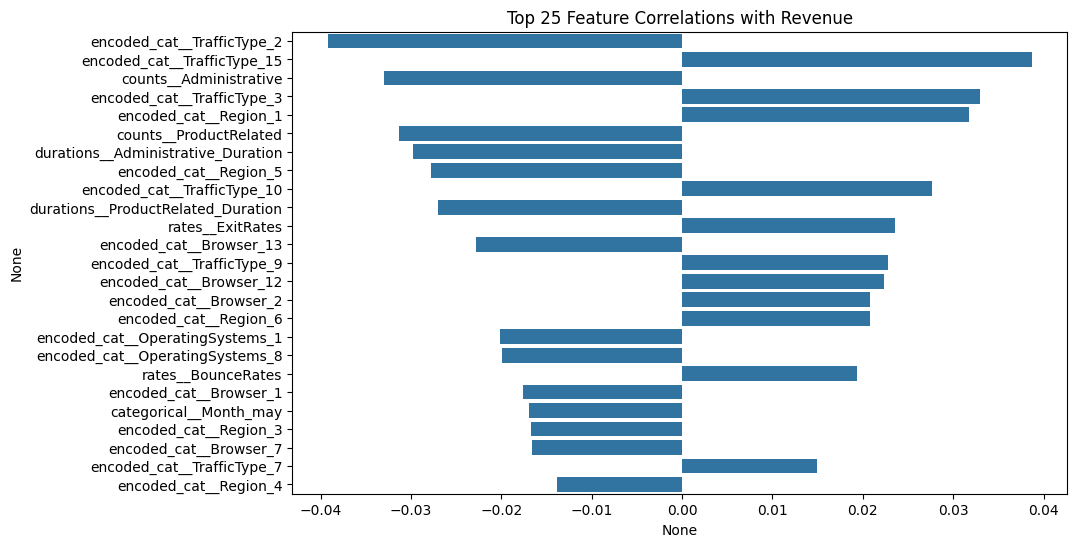

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the correlation matrix
corr_with_target = X_train_df.corrwith(y_train).sort_values(key=np.abs, ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=corr_with_target.head(25), y=corr_with_target.head(25).index)
plt.title("Top 25 Feature Correlations with Revenue")
plt.show()

In [119]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=35)
X_train_selected = rfe.fit_transform(X_train_df, y_train)
X_val_selected = rfe.transform(X_val_df)

selected_columns = X_train_df.columns[rfe.get_support()]

X_train_selected_df = pd.DataFrame(
    X_train_selected, 
    columns=selected_columns
)
X_val_selected_df = pd.DataFrame(
    X_val_selected, 
    columns=selected_columns
)



print("Original shape:", X_train_df.shape)
print("Reduced shape:", X_train_selected.shape)

Original shape: (8543, 73)
Reduced shape: (8543, 35)


In [120]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score, mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def train_and_save(model, X_train, y_train, X_test, y_test, model_name, results_dict):
    model.fit(X_train, y_train)

    print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
    print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))
    
    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', round(auc,3))
    
    # Collect metrics
    results_dict[model_name] = {
        'Train Accuracy': model.score(X_train, y_train),
        'Test Accuracy': model.score(X_test, y_test),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted')
    }
    
    return model, results_dict

In [121]:
def train_and_save_hyper(model, X_train, y_train, X_test, y_test, model_name, results_dict):
    model.fit(X_train, y_train)

    print('Model accuracy for train set: {0:.3f}'.format(model.score(X_train, y_train)))
    print('Model accuracy for test set: {0:.3f}'.format(model.score(X_test, y_test)))

    print("Best parameters found: ", model.best_params_)
    print("Best cross-validation score: ", model.best_score_)
    
    y_pred = model.predict(X_test)

    # Classification Report
    print('\n{}'.format(classification_report(y_test, y_pred)))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion Matrix:\n', cm)

    # Accuracy Score
    auc = accuracy_score(y_test, y_pred)
    print('\nAccuracy Score: ', round(auc,3))
    
    # Collect metrics
    results_dict[model_name] = {
        'Train Accuracy': model.score(X_train, y_train),
        'Test Accuracy': model.score(X_test, y_test),
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1': f1_score(y_test, y_pred, average='weighted')
    }
    
    return model, results_dict

Classification task:

In [122]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train_selected, y_train)
results_class = {}

Logistic Regression

In [123]:
from sklearn.linear_model import LogisticRegression

LR = LogisticRegression()

# Logistic Regression with hyperparameter tuning
params_log = {
    'C': [0.001, 0.01, 0.1, 1, 5],
    'solver': ['lbfgs'],
    'max_iter': [100,200,500]
}
skf = StratifiedKFold(n_splits = 10)
LR_hyper = GridSearchCV(LR, param_grid = params_log, n_jobs =-1, cv = skf)
model_LogR_hyper, results_class = train_and_save_hyper(LR_hyper, X_train_smote, y_train_smote, X_val_selected, y_val, "Logistic Regression Tuned", results_class)

Model accuracy for train set: 0.842
Model accuracy for test set: 0.850
Best parameters found:  {'C': 5, 'max_iter': 100, 'solver': 'lbfgs'}
Best cross-validation score:  0.8406418046490677

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1545
           1       0.51      0.80      0.62       286

    accuracy                           0.85      1831
   macro avg       0.74      0.83      0.77      1831
weighted avg       0.89      0.85      0.86      1831


Confusion Matrix:
 [[1329  216]
 [  58  228]]

Accuracy Score:  0.85


Random Forest

In [124]:
# Random Forest with hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

params_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 10],
    'max_features': ['sqrt'],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}

skf = StratifiedKFold(n_splits=10)
RF_hyper = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=params_rf, n_jobs=-1, cv=skf)
model_RF_hyper, results_class = train_and_save_hyper(
    RF_hyper, X_train_smote, y_train_smote, X_val_selected, y_val, "Random Forest Tuned", results_class
)

d:\project\bs_re\rmit_pds_asm3\.venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Model accuracy for train set: 0.939
Model accuracy for test set: 0.860
Best parameters found:  {'bootstrap': False, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation score:  0.904541363920301

              precision    recall  f1-score   support

           0       0.96      0.87      0.91      1545
           1       0.53      0.81      0.64       286

    accuracy                           0.86      1831
   macro avg       0.75      0.84      0.78      1831
weighted avg       0.89      0.86      0.87      1831


Confusion Matrix:
 [[1343  202]
 [  55  231]]

Accuracy Score:  0.86


In [125]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb.fit(X_train_smote, y_train_smote)

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",200
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",5
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, 

In [126]:
from sklearn.ensemble import VotingClassifier

hybrid_model = VotingClassifier(
    estimators=[('rf', model_RF_hyper.best_estimator_), ('gb', gb)],
    voting='soft'
)

hybrid_model.fit(X_train_smote, y_train_smote)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('rf', ...), ('gb', ...)]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2


In [127]:
from sklearn.metrics import classification_report

y_pred_hybrid = hybrid_model.predict(X_train_smote)
print(classification_report(y_train_smote, y_pred_hybrid))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93      7207
           1       0.92      0.96      0.94      7207

    accuracy                           0.93     14414
   macro avg       0.93      0.93      0.93     14414
weighted avg       0.93      0.93      0.93     14414



Clustering

In [128]:
X_train_processed_cluster = preprocess_clustering.fit_transform(X_train)
feature_names = preprocess_clustering.get_feature_names_out()

X_train_df_cluster = pd.DataFrame(X_train_processed_cluster, columns=feature_names)

X_val_processed_cluster = preprocess_clustering.transform(X_val)
X_val_df_cluster = pd.DataFrame(X_val_processed_cluster, columns=feature_names)

In [129]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=35)
X_train_selected_cluster = rfe.fit_transform(X_train_df_cluster, y_train)
X_val_selected_cluster = rfe.transform(X_val_df_cluster)

selected_columns = X_train_df_cluster.columns[rfe.get_support()]

X_train_selected_cluster_df = pd.DataFrame(
    X_train_selected_cluster, 
    columns=selected_columns
)
X_val_selected_cluster_df = pd.DataFrame(
    X_val_selected_cluster, 
    columns=selected_columns
)


print("Original shape:", X_train_df_cluster.shape)
print("Reduced shape:", X_train_selected_cluster_df.shape)

Original shape: (8543, 73)
Reduced shape: (8543, 35)


In [130]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Try different k values
silhouette_scores = {}
for k in range(2, 11):  # test k from 2 to 10
    kmeans_tmp = KMeans(n_clusters=k, random_state=0)
    labels_tmp = kmeans_tmp.fit_predict(X_train_selected_cluster_df)
    score = silhouette_score(X_train_selected_cluster_df, labels_tmp)
    silhouette_scores[k] = score
    print(f"k={k}, silhouette={score:.3f}")

# Choose the k with the highest silhouette score
best_k = max(silhouette_scores, key=silhouette_scores.get)
print("Best k:", best_k)


k=2, silhouette=0.535
k=3, silhouette=0.347
k=4, silhouette=0.163
k=5, silhouette=0.128
k=6, silhouette=0.147
k=7, silhouette=0.158
k=8, silhouette=0.224
k=9, silhouette=0.220
k=10, silhouette=0.231
Best k: 2


In [131]:
# K-Means Clustering
from sklearn.cluster import KMeans

# --- Clustering on selected features ---
kmeans = KMeans(n_clusters=best_k, random_state=0)
train_clusters = kmeans.fit_predict(X_train_selected_cluster_df)
val_clusters = kmeans.predict(X_val_selected_cluster_df)

# Add cluster labels as new feature
X_train_selected_cluster_df["KMeans_Cluster"] = train_clusters
X_val_selected_cluster_df["KMeans_Cluster"] = val_clusters


In [132]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

eps_values = [0.5, 1.0, 1.5, 2.0, 2.5, 3]       # candidate radii
min_samples_values = [3, 5, 7, 10]         # candidate densities

best_score = -1
best_params = None

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_train_selected_cluster_df)

        # Skip cases where DBSCAN assigns all points to noise (-1) or only one cluster
        if len(set(labels)) > 1 and not all(l == -1 for l in labels):
            score = silhouette_score(X_train_selected_cluster_df, labels)
            print(f"eps={eps}, min_samples={min_samples}, silhouette={score:.3f}")

            if score > best_score:
                best_score = score
                best_params = (eps, min_samples)

print("Best params:", best_params, "with silhouette:", best_score)


eps=0.5, min_samples=3, silhouette=0.181
eps=0.5, min_samples=5, silhouette=0.153
eps=0.5, min_samples=7, silhouette=0.125
eps=0.5, min_samples=10, silhouette=0.082
eps=1.0, min_samples=3, silhouette=-0.282
eps=1.0, min_samples=5, silhouette=-0.234
eps=1.0, min_samples=7, silhouette=-0.230
eps=1.0, min_samples=10, silhouette=-0.221
eps=1.5, min_samples=3, silhouette=0.274
eps=1.5, min_samples=5, silhouette=0.271
eps=1.5, min_samples=7, silhouette=0.298
eps=1.5, min_samples=10, silhouette=0.298
eps=2.0, min_samples=3, silhouette=0.352
eps=2.0, min_samples=5, silhouette=0.352
eps=2.0, min_samples=7, silhouette=0.357
eps=2.0, min_samples=10, silhouette=0.356
Best params: (2.0, 7) with silhouette: 0.3574883751561375


In [133]:
eps, min_samples = best_params
print("Using eps =", eps, "and min_samples =", min_samples)

# Fit DBSCAN on training features only (exclude cluster labels as features)
dbscan = DBSCAN(eps=2, min_samples=7)
train_clusters_db = dbscan.fit_predict(X_train_selected_cluster_df.drop(columns=["KMeans_Cluster"], errors="ignore"))
val_clusters_db = dbscan.fit_predict(X_val_selected_cluster_df.drop(columns=["KMeans_Cluster"], errors="ignore"))

# Add cluster labels as new feature to training set only (DBSCAN has no reliable predict)
X_train_selected_cluster_df["DBSCAN_Cluster"] = train_clusters_db
X_val_selected_cluster_df["DBSCAN_Cluster"] = val_clusters_db

# Show cluster label counts
print('KMeans cluster counts:')
print(X_train_selected_cluster_df['KMeans_Cluster'].value_counts())
print('\nDBSCAN cluster counts (train only):')
print(X_train_selected_cluster_df['DBSCAN_Cluster'].value_counts())

Using eps = 2.0 and min_samples = 7
KMeans cluster counts:
KMeans_Cluster
1    7916
0     627
Name: count, dtype: int64

DBSCAN cluster counts (train only):
DBSCAN_Cluster
 0    8541
-1       2
Name: count, dtype: int64


In [134]:
from sklearn.metrics import silhouette_score

# --- Prepare features (exclude cluster label columns) ---
feature_cols_for_sil = X_train_selected_cluster_df.columns.difference(
    ["KMeans_Cluster", "DBSCAN_Cluster"]
)
X_train_features_only = X_train_selected_cluster_df[feature_cols_for_sil]

# --- KMeans silhouette ---
kmeans_silhouette = silhouette_score(X_train_features_only, train_clusters)

# --- DBSCAN silhouette (ignore noise points) ---
dbscan_mask = train_clusters_db != -1
if dbscan_mask.sum() > 1 and len(set(train_clusters_db[dbscan_mask])) > 1:
    dbscan_silhouette = silhouette_score(
        X_train_features_only[dbscan_mask], train_clusters_db[dbscan_mask]
    )
else:
    dbscan_silhouette = None

# --- Compare results ---
print("Silhouette Score Comparison")
print("---------------------------")
print(f"KMeans: {kmeans_silhouette:.3f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN: {dbscan_silhouette:.3f}")
else:
    print("DBSCAN: Not enough clusters formed (all noise or single cluster)")


Silhouette Score Comparison
---------------------------
KMeans: 0.535
DBSCAN: Not enough clusters formed (all noise or single cluster)


Retrain new model with cluster label

In [141]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

X_train_for_model = X_train_selected_cluster_df.drop(columns=["DBSCAN_Cluster"], errors="ignore")
X_val_for_model = X_val_selected_cluster_df.drop(columns=["DBSCAN_Cluster"], errors="ignore")

X_train_smote_cluster, y_train_smote_cluster = smote.fit_resample(X_train_for_model, y_train)

In [143]:
# Random Forest with hyperparameter tuning
from sklearn.model_selection import GridSearchCV, StratifiedKFold

params_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4, 10],
    'max_features': ['sqrt'],
    'bootstrap': [True, False],
    'class_weight': ['balanced']
}
skf = StratifiedKFold(n_splits=10)
RF_hyper = GridSearchCV(RandomForestClassifier(random_state=0), param_grid=params_rf, n_jobs=-1, cv=skf)
model_RF_hyper_cluster, results_class = train_and_save_hyper(
    RF_hyper, X_train_smote_cluster, y_train_smote_cluster, X_val_for_model, y_val, "Random Forest Tuned Cluster", results_class
)

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

gb.fit(X_train_smote_cluster, y_train_smote_cluster)

,"loss loss: {'log_loss', 'exponential'}, default='log_loss'The loss function to be optimized. 'log_loss' refers to binomial andmultinomial deviance, the same as used in logistic regression.It is a good choice for classification with probabilistic outputs.For loss 'exponential', gradient boosting recovers the AdaBoost algorithm.",'log_loss'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.For an example of the effects of this parameter and its interaction with``subsample``, see:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_regularization.py`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",200
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are'friedman_mse' for the mean squared error with improvement score byFriedman, 'squared_error' for mean squared error. The default value of'friedman_mse' is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",5
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, 

In [ ]:
from sklearn.ensemble import VotingClassifier

hybrid_model = VotingClassifier(
    estimators=[('rf', model_RF_hyper_cluster.best_estimator_), ('gb', gb)],
    voting='soft'
)

hybrid_model.fit(X_train_smote_cluster, y_train_smote_cluster)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('rf', ...), ('gb', ...)]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",20
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",2


In [ ]:
from sklearn.metrics import classification_report

y_pred_hybrid = hybrid_model.predict(X_train_smote_cluster)
print(classification_report(y_train_smote_cluster, y_pred_hybrid))

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      7207
           1       0.92      0.96      0.94      7207

    accuracy                           0.94     14414
   macro avg       0.94      0.94      0.94     14414
weighted avg       0.94      0.94      0.94     14414



In [ ]:
# Logistic Regression with hyperparameter tuning
params_log = {
    'C': [0.001, 0.01, 0.1, 1, 5],
    'solver': ['lbfgs'],
    'max_iter': [100,200,500]
}
skf = StratifiedKFold(n_splits = 10)
LR_hyper = GridSearchCV(LR, param_grid = params_log, n_jobs =-1, cv = skf)
model_LogR_hyper_cluster, results_class = train_and_save_hyper(LR_hyper, X_train_smote_cluster, y_train_smote_cluster, X_val_for_model, y_val, "Logistic Regression Tuned Cluster", results_class)

Model accuracy for train set: 0.843
Model accuracy for test set: 0.851
Best parameters found:  {'C': 5, 'max_iter': 100, 'solver': 'lbfgs'}
Best cross-validation score:  0.8407805490292706

              precision    recall  f1-score   support

           0       0.96      0.86      0.91      1545
           1       0.51      0.80      0.63       286

    accuracy                           0.85      1831
   macro avg       0.74      0.83      0.77      1831
weighted avg       0.89      0.85      0.86      1831


Confusion Matrix:
 [[1330  215]
 [  58  228]]

Accuracy Score:  0.851
